<a href="https://colab.research.google.com/github/jejec0703/Dacon-Contest/blob/master/Final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.impute import KNNImputer
from tqdm.notebook import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 비식별화 자료 처리

In [ ]:
class serial_impute():
  
  def __init__(self,data):
    self.data=data
    self.amt=data[['REG_YYMM', 'STD_CLSS_NM','CARD_SIDO_NM','CSTMR_CNT','AMT','CNT']].groupby(['REG_YYMM', 'STD_CLSS_NM','CARD_SIDO_NM'],as_index=False).sum()
    self.sido_list = list(set(data['CARD_SIDO_NM']))
    self.std_list=list(set(data['STD_CLSS_NM']))
    self.month_list = list(set(data['REG_YYMM']))

#데이터 프레임 조작해서 원하는 형식으로 맞춰주기
  def pd_maker(self,sido,std):
    p_amt=self.amt[(self.amt['CARD_SIDO_NM']==sido)&(self.amt['STD_CLSS_NM']==std)]
    p_val=p_amt[['REG_YYMM','CSTMR_CNT','AMT']]
    p_val.replace(0,np.nan,inplace=True)
    p_val['MM']=p_val['REG_YYMM']%100
    p_val['YY']=p_val['REG_YYMM']//100
    p_val['MM']=p_val['MM'].astype(int)
    p_val['YY']=p_val['YY'].astype(int)
    amt_final=p_val[['YY','MM',"CSTMR_CNT",'AMT']]
    amt_final.reset_index(inplace=True)
    return amt_final

#비식별화 데이터 채워넣기 by sum(AMT) data
#원 데이터에서 submission 파일과 겹치는 칼럼 외의 칼럼들을 제거한 후 AMT를 더해주니
#도시, 업종별로 값이 존재하지 않는 데이터가 존재.
#비식별화 조치로 없어진 데이터는 추후에도 없어질 가능성이 높다 판단되 결측치 처리를 해줌.
#또는 추후에 생겨날 수 있는 데이터에 대해서도 고려해줌.
  def full_imputer(self):
    result_pd=pd.DataFrame(columns=['YY','MM','CARD_SIDO_NM','STD_CLSS_NM','AMT'])
    for sinan in tqdm(self.sido_list):
      for stnan in tqdm(self.std_list):
        sp_data=self.data[(self.data['CARD_SIDO_NM']==sinan)&(self.data['STD_CLSS_NM']==stnan)]    
        #위에서 만든 형태 지정 메소드 사용.
        amt_pd=self.pd_maker(sinan,stnan)
        #상관계수.
        d_corr=sp_data.corr()
        ca_corr=d_corr['CSTMR_CNT']['AMT']
        #값이 결측된 행이 10개 미만인 데이터에서만 impute 실행.
        if 0<amt_pd['AMT'].isnull().sum() <10:
        #상관계수가 0.66 이상인 데이터에 한해서 KNNImputer를 사용해 예측 실행.
        #CSTMR_CNT와 AMT의 전반적인 상관계수가 높기 때문 + 상관계수가 높아 예측값의 정확도도 높을 것이라 보기 때문.        
          if ca_corr>0.66:
            imputer = KNNImputer(n_neighbors=3, weights="uniform")
            nn_pd=pd.DataFrame(imputer.fit_transform(amt_pd))
            nn_pd.columns=amt_pd.columns
            nn_pd['CARD_SIDO_NM']=str(sinan)
            nn_pd['STD_CLSS_NM']=str(stnan)
            result_pd=pd.concat([result_pd,nn_pd[['YY','MM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]])
          else:
        #울산 면세점, 전북 면세점 같은 경우는 값이 치우쳐짐 + 최근 데이터 결측이 심해 0으로 채워줌.
            if ((sinan=='울산')&(stnan=='면세점'))|((sinan=='전북')&(stnan=='내항 여객 운송업')):
              amt_pd.replace(np.nan,0,inplace=True)
              amt_pd['CARD_SIDO_NM']=str(sinan)
              amt_pd['STD_CLSS_NM']=str(stnan)
              result_pd=pd.concat([result_pd,amt_pd[['YY','MM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]])
            else:
        #그 외의 데이터는 Iterativeimputer의 BayesianRidge를 활용해 결측치 처리.
        #결측이 있어도 나타날 가능성이 있다 판단되는 데이터들.
        #median 값을 사용.
              cc_pd=amt_pd[['YY','MM','AMT']]
              nn_pd = pd.DataFrame(IterativeImputer(random_state=8,initial_strategy='median',estimator=BayesianRidge()).fit_transform(cc_pd.values))
              nn_pd.columns=cc_pd.columns
              nn_pd['CARD_SIDO_NM']=str(sinan)
              nn_pd['STD_CLSS_NM']=str(stnan)
              result_pd=pd.concat([result_pd,nn_pd[['YY','MM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]])
        #결측된 행이 10개 이상이면 비식별화 확률이 높다 판단하여 모두 0으로 채워주었다.
        else:
          amt_pd.replace(np.nan,0,inplace=True)
          amt_pd['CARD_SIDO_NM']=str(sinan)
          amt_pd['STD_CLSS_NM']=str(stnan)
          result_pd=pd.concat([result_pd,amt_pd[['YY','MM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]])
    result_pd=result_pd.reset_index()
  
    return result_pd[['YY','MM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]

In [ ]:
#원본 데이터(201901-202003) 가져오기
data_jj=pd.read_csv('/content/drive/My Drive/data/dacon_data/201901-202003.csv')
#submission 가져오기
sub=pd.read_csv('/content/drive/My Drive/data/dacon_data/submission.csv')

In [ ]:
#04 월 데이터
data_04=pd.read_csv('/content/drive/My Drive/data/dacon_data/202004.csv')

In [ ]:
#비식별 데이터를 처리하기 위해 submission 기준으로 필요한 칼럼들을 뽑아옴.

sido_list = list(set(data_jj['CARD_SIDO_NM']))
std_list=list(set(data_jj['STD_CLSS_NM']))
month_list = list(set(data_jj['REG_YYMM']))

In [ ]:
# NaN 데이터 생성. 0또는 결측값 채워주기 위한 용도

data_nan_n =[]
for month in month_list:
  for sido in sido_list:
    for std in std_list:
      data_nans=[int(month),sido,std,np.nan,np.nan,np.nan]
      data_nan_n.append(data_nans)
data_n=pd.DataFrame(data_nan_n,
                    columns=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM','CSTMR_CNT','AMT','CNT'])
data_jj_n=pd.concat([data_jj,data_n],ignore_index=True)

In [ ]:
# 비식별화 데이터 처리.
full_class=serial_impute(data_jj_n)
full_nn=full_class.full_imputer()

In [ ]:
full_nn

,YY,MM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,2019,1,충남,일식 음식점업,1.568256e+09
1,2019,2,충남,일식 음식점업,1.418196e+09
2,2019,3,충남,일식 음식점업,1.652410e+09
3,2019,4,충남,일식 음식점업,1.507280e+09
4,2019,5,충남,일식 음식점업,1.525868e+09
...,...,...,...,...,...
10450,2019,11,경남,화장품 및 방향제 소매업,1.725765e+09
10451,2019,12,경남,화장품 및 방향제 소매업,1.678158e+09
10452,2020,1,경남,화장품 및 방향제 소매업,1.641507e+09
10453,2020,2,경남,화장품 및 방향제 소매업,1.381197e+09


# 군집처리
refer : https://www.kaggle.com/mbnb8317/m5-cluster-zero-one-sales-pattern

In [ ]:
################################################
##### 도별-업종별 월별 데이터의 행 수 파악 #####
################################################

std_list=list(set(data['STD_CLSS_NM']))
sido_list=list(set(data['CARD_SIDO_NM']))
month_set = set(data['REG_YYMM'])

row_num_df = pd.DataFrame(np.zeros(2)).T
row_num_df.columns=['SIDO-STD-Month','row-num']
strange_sido_std_month_list = []

for sido in sido_list:
    data_by_sido=data[data['CARD_SIDO_NM']==sido]
    for std in std_list:
        data_by_nm = data_by_sido[data_by_sido['STD_CLSS_NM']==std]
        for month in list(month_set):
            data_by_month = data_by_nm[data_by_nm['REG_YYMM']==month]
            row_num_df_tmp = {'SIDO-STD-Month':sido+'-'+std+'의'+' '+str(month),'row-num':len(data_by_month)}
            row_num_df = row_num_df.append(row_num_df_tmp, ignore_index = True)
            if len(data_by_month)<=100: #행의 수가 일정 수준 이하이면 체크
                strange_sido_std_month_list.append(sido+'-'+std+'의 '+str(month))
                                
row_num_df.index = range(0,len(row_num_df))
row_num_df=row_num_df.drop(0)

In [ ]:
##################################################################################################
##### 도별, 업종별 데이터를 월별 집계 후, 특정 월에 데이터가 없는 경우 집계 셀을 NA로 채운다 #####
##################################################################################################

#####  도별&업종별 데이터 월별 AMT 집계(mean, min, max) 

monthly_SUM_by_SIDO=data[['AMT', 'REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM']].groupby(['REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM'],as_index=False).sum()
monthly_SUM_by_SIDO.columns = ['REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM','AMT_SUM']
monthly_MEAN_by_SIDO=data[['AMT', 'REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM']].groupby(['REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM'],as_index=False).mean()
monthly_MEAN_by_SIDO.columns = ['REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM','AMT_MEAN']
monthly_MIN_by_SIDO=data[['AMT', 'REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM']].groupby(['REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM'],as_index=False).min()
monthly_MIN_by_SIDO.columns = ['REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM','AMT_MIN']
monthly_MAX_by_SIDO=data[['AMT', 'REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM']].groupby(['REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM'],as_index=False).max()
monthly_MAX_by_SIDO.columns = ['REG_YYMM', 'STD_CLSS_NM', 'CARD_SIDO_NM','AMT_MAX']

##### 월별 AMT 집계(mean, min, max) 병합

monthly_AMT_by_SIDO=pd.merge(monthly_SUM_by_SIDO,monthly_MEAN_by_SIDO,how='left')
monthly_AMT_by_SIDO=pd.merge(monthly_AMT_by_SIDO,monthly_MIN_by_SIDO,how='left')
monthly_AMT_by_SIDO=pd.merge(monthly_AMT_by_SIDO,monthly_MAX_by_SIDO,how='left')

##### 결측치(월)가 있는 도별 업종별 데이터 체크

tmp_df = pd.DataFrame(np.zeros(7)).T
tmp_df.columns=['REG_YYMM','STD_CLSS_NM','CARD_SIDO_NM','AMT_SUM','AMT_MEAN','AMT_MIN','AMT_MAX']
monthly_amt_by_SIDO = tmp_df

sido_std_month_null_list = []
sido_std_null_list = []

for sido in sido_list:
    tmp_df_by_sido=monthly_AMT_by_SIDO[monthly_AMT_by_SIDO['CARD_SIDO_NM']==sido]
    for std in std_list:
        tmp_df_by_nm = tmp_df_by_sido[tmp_df_by_sido['STD_CLSS_NM']==std]
        if tmp_df_by_nm.shape[0] != 15:
            null_month_set = month_set - set(tmp_df_by_nm['REG_YYMM']) 
            print(sido,'-',std,'은 결측되어 있다. 결측 연월은')
            print(null_month_set, '\n') 
            sido_std_null_list.append(sido+'-'+std)
            for month in list(null_month_set):
                sido_std_month_null_list.append(sido+'-'+std+'의 '+str(month))
                null_row = {'REG_YYMM':month,'STD_CLSS_NM':std,'CARD_SIDO_NM':sido,'AMT_SUM':np.nan,'AMT_MEAN':np.nan,'AMT_MIN':np.nan,'AMT_MAX':np.nan}
                tmp_df_by_nm = tmp_df_by_nm.append(null_row, ignore_index=True)
                tmp_df_by_nm = tmp_df_by_nm.sort_values(by='REG_YYMM')
        monthly_amt_by_SIDO = pd.concat([monthly_amt_by_SIDO,tmp_df_by_nm],axis=0)
    
monthly_amt_by_SIDO.index = range(0,len(monthly_amt_by_SIDO))    
monthly_amt_by_SIDO=monthly_amt_by_SIDO.drop(0)
#monthly_amt_by_SIDO.to_csv('monthly_AMT_by_SIDO.csv',encoding='euc-kr') #월별 집계 저장
#null_list

In [ ]:
CARD_SIDO_plus_STD = []
for i in range(len(monthly_amt_by_SIDO)):
    temp = monthly_amt_by_SIDO['CARD_SIDO_NM'].iloc[i]+'-'+monthly_amt_by_SIDO['STD_CLSS_NM'].iloc[i]
    CARD_SIDO_plus_STD.append(temp)
monthly_amt_by_SIDO['CARD_SIDO_plus_STD'] = CARD_SIDO_plus_STD 

In [ ]:
pivot_df = monthly_amt_by_SIDO[['REG_YYMM','CARD_SIDO_plus_STD','AMT_SUM']].pivot(index = 'CARD_SIDO_plus_STD',columns='REG_YYMM').reset_index()
ids = pd.DataFrame(pivot_df['CARD_SIDO_plus_STD'])
ids.index = range(0,len(ids))

In [ ]:
id_removed_pivot_df = pivot_df.iloc[:,1:]
pivot_scaled = (id_removed_pivot_df - id_removed_pivot_df.mean(axis=0)) /id_removed_pivot_df.std(axis=0)

In [ ]:
grid_df=pd.DataFrame(np.where(pivot_scaled.isnull(), np.nan, np.where(pivot_scaled>0,1,-1)))
grid_df.columns = pivot_scaled.columns
grid_df.index = pivot_df['CARD_SIDO_plus_STD']
grid_df

AMT_SUM                    ...                           
REG_YYMM                 201901.0 201902.0 201903.0  ... 202001.0 202002.0 202003.0
CARD_SIDO_plus_STD                                   ...                           
강원-건강보조식품 소매업                -1.0     -1.0     -1.0  ...     -1.0     -1.0     -1.0
강원-골프장 운영업                   -1.0     -1.0     -1.0  ...     -1.0     -1.0     -1.0
강원-과실 및 채소 소매업               -1.0     -1.0     -1.0  ...     -1.0     -1.0     -1.0
강원-관광 민예품 및 선물용품 소매업         -1.0     -1.0     -1.0  ...     -1.0     -1.0     -1.0
강원-그외 기타 분류안된 오락관련 서비스업       NaN      NaN      NaN  ...      NaN      NaN      NaN
...                           ...      ...      ...  ...      ...      ...      ...
충북-피자 햄버거 샌드위치 및 유사 음식점업     -1.0     -1.0     -1.0  ...     -1.0     -1.0     -1.0
충북-한식 음식점업                    1.0      1.0      1.0  ...      1.0      1.0      1.0
충북-호텔업                       -1.0     -1.0     -1.0  ...     -1.0     -1.0     -1.0
충북-화장품 및 방향제 소매업             -1.0     -1.0     -1.0  ...     -1.0     -1.0     -1.0
충북-휴양콘도 운영업                  -1.0     -1.0     -1.0  ...     -1.0     -1.0     -1.0

[697 rows x 15 columns]

In [ ]:
import copy
grid_df_null_sum = grid_df.notnull().sum(axis=1)
cluster=copy.deepcopy(grid_df_null_sum)

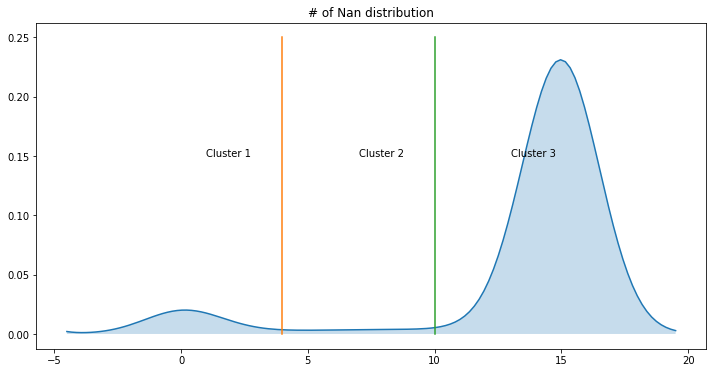

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.kdeplot(grid_df_null_sum,shade=True, bw=1.5)
plt.plot([4,4],[0,0.25]); plt.plot([10,10],[0,0.25])
plt.text(x=1,y=0.15,s='Cluster 1'); plt.text(x=7,y=0.15,s='Cluster 2');plt.text(x=13,y=0.15,s='Cluster 3')
plt.title('# of Nan distribution')
plt.show()

In [ ]:
for i in range(len(grid_df_null_sum)):
    if grid_df_null_sum[i] <= 4:
        cluster[i] = 1
    elif grid_df_null_sum[i] > 4 and grid_df_null_sum[i] <= 10:
        cluster[i] = 2
    else :
        cluster[i] = 3
cluster

CARD_SIDO_plus_STD
강원-건강보조식품 소매업               3
강원-골프장 운영업                  3
강원-과실 및 채소 소매업              3
강원-관광 민예품 및 선물용품 소매업        3
강원-그외 기타 분류안된 오락관련 서비스업     1
                           ..
충북-피자 햄버거 샌드위치 및 유사 음식점업    3
충북-한식 음식점업                  3
충북-호텔업                      3
충북-화장품 및 방향제 소매업            3
충북-휴양콘도 운영업                 3
Length: 697, dtype: int64

In [ ]:
grid_df['cluster'] = cluster
grid_df = grid_df.fillna(0)
grid_df['cluster'].value_counts()

3    624
1     58
2     15
Name: cluster, dtype: int64

In [ ]:
grid_df.columns = ['201901','201902','201903','201904','201905','201906','201907','201908','201909','201910','201911','201912','202001','201902','201903','cluster']
grid_df

,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,201902,201903,cluster
CARD_SIDO_plus_STD,,,,,,,,,,,,,,,,
강원-건강보조식품 소매업,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3
강원-골프장 운영업,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3
강원-과실 및 채소 소매업,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3
강원-관광 민예품 및 선물용품 소매업,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3
강원-그외 기타 분류안된 오락관련 서비스업,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
충북-피자 햄버거 샌드위치 및 유사 음식점업,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3
충북-한식 음식점업,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3
충북-호텔업,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3


In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster

In [ ]:
def Clustering1(df, cluster_lv1_name, cluster_lv2_num):
    cluster_df = df[df['cluster'] == cluster_lv1_name]
    if cluster_lv2_num == 1:
        print('Pass : Cluster', cluster_lv1_name)
        
    else:
        print('Making dist_matrix : Cluster', cluster_lv1_name)
        cluster_array = cluster_df.values[:,:-1]
        dist_matrix = np.dot(cluster_array, cluster_array.T)

        ## this part, linkage, takes about 30 minutes.
        ## If you have another idea for reducing running time,
        ## Please advise me !
        Z = linkage(dist_matrix, method='ward')
        cluster_num = fcluster(Z, t=cluster_lv2_num, criterion='maxclust')
        cluster_df['cluster'] = cluster_df['cluster'].astype(str) + '_' + cluster_num.astype(str)

    return cluster_df

In [ ]:
plan_clustering1 = {
    #cluster_lv1_name : how many cluster_lv2 to make
    1:1,
    2:1,
    3:2
}

In [ ]:
%time
cluster_DF1 = pd.DataFrame(np.zeros(16)).T
cluster_DF1.columns=['201901','201902','201903','201904','201905','201906','201907','201908','201909','201910','201911','201912','202001','201902','201903','cluster']
for lv1, lv2 in plan_clustering1.items():

    cluster_df1 = Clustering1(df = grid_df, cluster_lv1_name = lv1, cluster_lv2_num = lv2)
    cluster_DF1 = pd.concat([cluster_DF1, cluster_df1],axis=0)
    
cluster_DF1 = cluster_DF1.drop(0)
cluster_DF1.index.name = 'CARD_SIDO_plus_STD'
cluster_DF1

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
Pass : Cluster 1
Pass : Cluster 2
Making dist_matrix : Cluster 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,201902,201903,cluster
CARD_SIDO_plus_STD,,,,,,,,,,,,,,,,
강원-그외 기타 분류안된 오락관련 서비스업,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
강원-정기 항공 운송업,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
경기-그외 기타 분류안된 오락관련 서비스업,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,1
경기-면세점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
경기-정기 항공 운송업,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
충북-피자 햄버거 샌드위치 및 유사 음식점업,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3_2
충북-한식 음식점업,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3_1
충북-호텔업,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3_2


In [ ]:
def Clustering2(df, cluster_lv1_name, cluster_lv2_num):
    cluster_df = df[df['cluster'] == cluster_lv1_name]
    if cluster_lv2_num == 1:
        print('Pass : Cluster', cluster_lv1_name)
    else:
        print('Making dist_matrix : Cluster', cluster_lv1_name)
        cluster_array = cluster_df.values[:,:-2]
        dist_matrix = np.dot(cluster_array, cluster_array.T)

        ## this part, linkage, takes about 30 minutes.
        ## If you have another idea for reducing running time,
        ## Please advise me !
        Z = linkage(dist_matrix, method='ward')
        cluster_num = fcluster(Z, t=cluster_lv2_num, criterion='maxclust')
        cluster_df['cluster'] = cluster_df['cluster'].astype(str) + '_' + cluster_num.astype(str)

    return cluster_df

In [ ]:
plan_clustering2 = {
    #cluster_lv1_name : how many cluster_lv2 to make
    1:1,
    2:1,
    '3_1':1,
    '3_2':2
}

In [ ]:
%time
cluster_DF2 = pd.DataFrame(np.zeros(16)).T
cluster_DF2.columns=['201901','201902','201903','201904','201905','201906','201907','201908','201909','201910','201911','201912','202001','201902','201903','cluster']
for lv1, lv2 in plan_clustering2.items():

    cluster_df2 = Clustering1(df = cluster_DF1, cluster_lv1_name = lv1, cluster_lv2_num = lv2)
    cluster_DF2 = pd.concat([cluster_DF2, cluster_df2],axis=0)
    
cluster_DF2 = cluster_DF2.drop(0)
cluster_DF2.index.name = 'CARD_SIDO_plus_STD'
cluster_DF2

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
Pass : Cluster 1
Pass : Cluster 2
Pass : Cluster 3_1
Making dist_matrix : Cluster 3_2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,201902,201903,cluster
CARD_SIDO_plus_STD,,,,,,,,,,,,,,,,
강원-그외 기타 분류안된 오락관련 서비스업,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
강원-정기 항공 운송업,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
경기-그외 기타 분류안된 오락관련 서비스업,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,1
경기-면세점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
경기-정기 항공 운송업,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
충북-택시 운송업,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3_2_2
충북-피자 햄버거 샌드위치 및 유사 음식점업,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3_2_2
충북-호텔업,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3_2_2


In [ ]:
cluster_DF2['CARD_SIDO_plus_STD'] = cluster_DF2.index
cluster_DF2.index = range(0,len(cluster_DF2))
cluster_DF2

,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,201902,201903,cluster,CARD_SIDO_plus_STD
0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,강원-그외 기타 분류안된 오락관련 서비스업
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,강원-정기 항공 운송업
2,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,1,경기-그외 기타 분류안된 오락관련 서비스업
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,경기-면세점
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,경기-정기 항공 운송업
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3_2_2,충북-택시 운송업
693,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3_2_2,충북-피자 햄버거 샌드위치 및 유사 음식점업
694,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3_2_2,충북-호텔업
695,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3_2_2,충북-화장품 및 방향제 소매업


In [ ]:
pivot_df.columns = ['CARD_SIDO_plus_STD','201901','201902','201903','201904','201905','201906','201907','201908','201909','201910','201911','201912','202001','201902','201903']

pivot_plus_cluster_df = pd.merge(pivot_df,cluster_DF2[['CARD_SIDO_plus_STD','cluster']],on='CARD_SIDO_plus_STD',how='left')
monthly_amt_by_SIDO_plus_cluster_df = pd.merge(monthly_amt_by_SIDO,cluster_DF2[['CARD_SIDO_plus_STD','cluster']],on='CARD_SIDO_plus_STD',how='left')

In [ ]:
monthly_amt_by_SIDO_plus_cluster_df.head()

,REG_YYMM,STD_CLSS_NM,CARD_SIDO_NM,AMT_SUM,AMT_MEAN,AMT_MIN,AMT_MAX,CARD_SIDO_plus_STD,cluster
0,201901.0,일식 음식점업,충남,1.568256e+09,1.452089e+06,29000.0,54381770.0,충남-일식 음식점업,3_2_2
1,201902.0,일식 음식점업,충남,1.418196e+09,1.364962e+06,26000.0,50099140.0,충남-일식 음식점업,3_2_2
2,201903.0,일식 음식점업,충남,1.652410e+09,1.280938e+06,17500.0,68665000.0,충남-일식 음식점업,3_2_2
3,201904.0,일식 음식점업,충남,1.507280e+09,1.248782e+06,16800.0,56979600.0,충남-일식 음식점업,3_2_2
4,201905.0,일식 음식점업,충남,1.525868e+09,1.247644e+06,15800.0,62004980.0,충남-일식 음식점업,3_2_2


In [ ]:
monthly_amt_by_SIDO_plus_cluster_df['cluster'].value_counts()

3_2_2    7440
3_1      1785
1.0       870
2.0       225
3_2_1     135
Name: cluster, dtype: int64

In [ ]:
monthly_amt_by_SIDO_plus_cluster_df[['CARD_SIDO_NM','STD_CLSS_NM','CARD_SIDO_plus_STD','cluster']]

,CARD_SIDO_NM,STD_CLSS_NM,CARD_SIDO_plus_STD,cluster
0,충남,일식 음식점업,충남-일식 음식점업,3_2_2
1,충남,일식 음식점업,충남-일식 음식점업,3_2_2
2,충남,일식 음식점업,충남-일식 음식점업,3_2_2
3,충남,일식 음식점업,충남-일식 음식점업,3_2_2
4,충남,일식 음식점업,충남-일식 음식점업,3_2_2
...,...,...,...,...
10450,경남,화장품 및 방향제 소매업,경남-화장품 및 방향제 소매업,3_2_2
10451,경남,화장품 및 방향제 소매업,경남-화장품 및 방향제 소매업,3_2_2
10452,경남,화장품 및 방향제 소매업,경남-화장품 및 방향제 소매업,3_2_2
10453,경남,화장품 및 방향제 소매업,경남-화장품 및 방향제 소매업,3_2_2


In [ ]:
na_base= monthly_amt_by_SIDO_plus_cluster_df[['CARD_SIDO_NM','STD_CLSS_NM','CARD_SIDO_plus_STD','cluster']]

In [ ]:
# 데이터 병합을 위한 처리.
na_b=na_base[['CARD_SIDO_NM','STD_CLSS_NM','cluster']]
na_dp=na_b.drop_duplicates()

In [ ]:
# 4월에 비식별화된 데이터가 많다 판단해 3월까지의 데이터를 사용해 학습을 시켜주기로 결정.
full_n3=full_nn.merge(na_dp,how='inner',on=['CARD_SIDO_NM','STD_CLSS_NM'])

In [ ]:
full_n3

,YY,MM,CARD_SIDO_NM,STD_CLSS_NM,AMT,cluster
0,2019,1,충남,일식 음식점업,1.568256e+09,3_2_2
1,2019,2,충남,일식 음식점업,1.418196e+09,3_2_2
2,2019,3,충남,일식 음식점업,1.652410e+09,3_2_2
3,2019,4,충남,일식 음식점업,1.507280e+09,3_2_2
4,2019,5,충남,일식 음식점업,1.525868e+09,3_2_2
...,...,...,...,...,...,...
10450,2019,11,경남,화장품 및 방향제 소매업,1.725765e+09,3_2_2
10451,2019,12,경남,화장품 및 방향제 소매업,1.678158e+09,3_2_2
10452,2020,1,경남,화장품 및 방향제 소매업,1.641507e+09,3_2_2
10453,2020,2,경남,화장품 및 방향제 소매업,1.381197e+09,3_2_2


In [ ]:
# predict(제출) 데이터의 형식도 맞춰줌. 
sub_nab=sub.merge(na_dp,how='inner',on=['CARD_SIDO_NM','STD_CLSS_NM'])
sub_nab.sort_values(by='id',inplace=True)

# 데이터 변형

In [ ]:
class x_y_maker():
  def __init__(self,data):
    self.data=data
    #데이터 카피
    self.ori_data=data.copy()
    #AGE->AGE_GROUP
    #시도간 이동 라벨링
    self.encoder_s=LabelEncoder()
    self.encoder_c=LabelEncoder() 
    self.encoder_cls=LabelEncoder()
    self.stscaler=StandardScaler()

#특성 더 넣고 싶은 게 있으면 여기서 칼럼 만들어주면 된다.
#잘 모르겠으면 그냥 물어봐줘...
  
  def col_setting(self,full_data):
    #STD_CLSS_LB 만들기 (업종 데이터 라벨화)
    sample_label_s=self.encoder_s.transform(full_data['STD_CLSS_NM'])
    full_data['STD_CLSS_LB']=sample_label_s
    #CARD_SIDO_LB 만들기 (시도 데이터 라벨화)
    sample_label_c=self.encoder_c.transform(full_data['CARD_SIDO_NM'])
    full_data['CARD_SIDO_LB']=sample_label_c
    #cluster 라벨화
    sample_label_cls=self.encoder_cls.transform(full_data['cluster'])
    full_data['CLUS_LB']=sample_label_cls
    # MM, YY 나눠주기
    #필요한 칼럼만 축소
    actual_data=full_data[['YY','MM', 'CARD_SIDO_LB', 'STD_CLSS_LB','CLUS_LB','AMT']]
    
    return actual_data 

    # 원데이터 변형
  def data_maker(self):
    # CARD_CCG_NM, HOM_SIDO_NM, HOM_CCG_NM, SEX_CTGO, AGE, AGE_GROUP, CSTMR_CNT, CNT 삭제
    # CSTMR_CNT, CNT를 SUB에 반영할 수가 없다. ㅠ
    # 원데이터에서는 따로 NaN을 집어넣어주지 않음. NaN 때문에 학습이 안되서.
    # 만약 결측치 처리한 게 있으면 원데이터 대신 넣어주면 된다.
    mak_data=self.ori_data[['YY','MM', 'CARD_SIDO_NM', 'STD_CLSS_NM','cluster',
                            'AMT']].groupby(['YY','MM', 'CARD_SIDO_NM', 'STD_CLSS_NM','cluster']).agg(['sum']).reset_index()
    mak_data.columns=['YY','MM', 'CARD_SIDO_NM', 'STD_CLSS_NM','cluster','AMT']
    #라벨 인코딩
    self.encoder_s.fit(mak_data['STD_CLSS_NM'])
    self.encoder_c.fit(mak_data['CARD_SIDO_NM'])
    self.encoder_cls.fit(mak_data['cluster'])
    t_data=self.col_setting(mak_data)
    X_t=t_data[['YY','MM', 'CARD_SIDO_LB', 'STD_CLSS_LB','CLUS_LB']]
    y_ft=t_data[['AMT']]
    #기울어진 데이터 => log변환 후 StandardScaling
    y_ts=self.stscaler.fit_transform(np.log1p(y_ft))
    #shape 맞춰주기
    y_t=y_ts.flatten()
    return X_t, y_t

    # sub데이터 변형
  def sub_maker(self,sub):
    sub_m=sub.copy()
    sub_m['YY']=sub_m['REG_YYMM']//100
    sub_m['MM']=sub_m['REG_YYMM']%100
    sub_data=self.col_setting(sub_m)
    X_s=sub_data[['YY','MM', 'CARD_SIDO_LB', 'STD_CLSS_LB','CLUS_LB']]
    y_fs=sub_data[['AMT']]
    #shape 맞춰주기
    y_s=y_fs.values.flatten()
    return X_s, y_s

    # sub데이터 디코드, sub_t에는 서브미션에서 AMT제외한 거, sub_p에는 predict value 넣어주면 됨.
  def sub_decoder(self,sub_t,sub_p):
    sub_d=sub_t.copy()
    sub_d=sub_d[['YY','MM', 'CARD_SIDO_LB', 'STD_CLSS_LB']]
    #CARD SIDO, STD CLSS 디코딩
    sub_d['STD_CLSS_NM']=self.encoder_s.inverse_transform(sub_d['STD_CLSS_LB'])
    sub_d['CARD_SIDO_NM']=self.encoder_c.inverse_transform(sub_d['CARD_SIDO_LB'])
    #연도 돌려주기
    sub_d['REG_YYMM']=sub_d['YY']*100+sub_d['MM']
    #Standard Scaling decoding
    st_p=self.stscaler.inverse_transform(sub_p)
    #log1p decoding
    fin_p= np.expm1(st_p)
    #소수값 반올림
    sub_d['AMT']=np.round(fin_p,0)
    #50미만 0으로 환원
    sub_d['AMT']=np.where(sub_d['AMT']<50,0,sub_d['AMT'])
    #최종 셋 맞춰주기
    sub_d=sub_d[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
    return sub_t

In [ ]:
#객체 생성
xy_maker = x_y_maker(full_n3)

In [ ]:
# 객체 내 메서드 실행 => 원 데이터 변형
x,y=xy_maker.data_maker()
# 객체 내 메서드 실행 => sub 데이터 변형
X_sub, y_sub=xy_maker.sub_maker(sub_nab)

# 학습

In [ ]:
# 트레인, 테스트 셋 분리 random_state=777
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.3, random_state=777,shuffle = True)

In [ ]:
xgb_final=xgb.XGBRegressor(alpha=0.03,colsample_bytree=0.7,learning_rate=0.05,max_depth=10,
                      min_child_weight=2,n_estimators=2500,random_state=545,objective='reg:squarederror',
                     subsample=0.7,reg_lambda=0.01)

In [ ]:
xgb_final.fit(X_train,y_train)

XGBRegressor(alpha=0.03, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=2, missing=None, n_estimators=2500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=545, reg_alpha=0, reg_lambda=0.01, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=1)

In [ ]:
xgb_final.score(X_test,y_test)

0.9676084916530527

In [ ]:
xgb_final.fit(x,y,verbose=0)
submiss=xy_maker.sub_decoder(X_sub,xgb_final.predict(X_sub))

In [ ]:
submiss.index.name='id'
submiss.to_csv('/content/drive/My Drive/Dacon/final_submission/test.csv', encoding='utf-8-sig')